## Building a GPT

The goal of this notebook is to introduce self-attention mechanism and understand the architecture behind GPT model.

The notebook is heavily based on the great materials by [Andrej Karpathy](https://karpathy.ai/zero-to-hero.html)

In [1]:
# The dataset we are using today is tiny shakespeare
# Which represents a huge text composed of different texts by Shakespeare

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-12-11 22:13:40--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  6.50MB/s    in 0.2s    

2024-12-11 22:13:40 (6.50 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# some variables-helpers

In [5]:
# here are all the unique characters that occur in this text

# list of unique characters
chars = set(text)
# how many distinct characters there're in the text
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

yolR;jVCAimuUJKOL$&PXhdIbx aTgsYnN.HDerZ'GMcBSEp3k-f
wz,t!qQFWv?:
65


In [6]:
# create a mapping from characters to integers

# string to integer mapping
stoi = {char: idx for idx, char in enumerate(chars)}
# integer to string mapping
itos = {idx: char for idx, char in enumerate(chars)}
# function that takes a string, outputs a list of integers
encode = lambda s: [stoi[c] for c in s]
# function that takes a list of integers, outputs a string
decode = lambda l: "".join([itos[i] for i in l])

print(encode("hii there"))
print(decode(encode("hii there")))

[21, 9, 9, 26, 56, 21, 37, 38, 37]
hii there


In [7]:
import torch


# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([60,  9, 38, 30, 56, 26,  7,  9, 56,  9, 54, 37, 32, 64, 52, 44, 37, 51,
         1, 38, 37, 26, 53, 37, 26, 47, 38,  1, 43, 37, 37, 22, 26, 27, 32,  0,
        26, 51, 11, 38, 56, 21, 37, 38, 55, 26, 21, 37, 27, 38, 26, 10, 37, 26,
        30, 47, 37, 27, 49, 34, 52, 52,  8,  2,  2, 64, 52, 45, 47, 37, 27, 49,
        55, 26, 30, 47, 37, 27, 49, 34, 52, 52, 60,  9, 38, 30, 56, 26,  7,  9,
        56,  9, 54, 37, 32, 64, 52, 31,  1, 11, 26, 27, 38, 37, 26, 27,  2,  2,
        26, 38, 37, 30,  1,  2, 62, 37, 22, 26, 38, 27, 56, 21, 37, 38, 26, 56,
         1, 26, 22,  9, 37, 26, 56, 21, 27, 32, 26, 56,  1, 26, 51, 27, 10,  9,
        30, 21, 63, 52, 52,  8,  2,  2, 64, 52,  3, 37, 30,  1,  2, 62, 37, 22,
        34, 26, 38, 37, 30,  1,  2, 62, 37, 22, 34, 52, 52, 60,  9, 38, 30, 56,
        26,  7,  9, 56,  9, 54, 37, 32, 64, 52, 60,  9, 38, 30, 56, 55, 26,  0,
         1, 11, 26, 49, 32,  1, 53, 26,  7, 27,  9, 11, 30, 26, 42, 27, 38, 43,
      

In [8]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

tensor([60,  9, 38, 30, 56, 26,  7,  9, 56])

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([60]) the target: 9
when input is tensor([60,  9]) the target: 38
when input is tensor([60,  9, 38]) the target: 30
when input is tensor([60,  9, 38, 30]) the target: 56
when input is tensor([60,  9, 38, 30, 56]) the target: 26
when input is tensor([60,  9, 38, 30, 56, 26]) the target: 7
when input is tensor([60,  9, 38, 30, 56, 26,  7]) the target: 9
when input is tensor([60,  9, 38, 30, 56, 26,  7,  9]) the target: 56


In [13]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[16, 37, 56, 40, 30, 26, 21, 37],
        [51,  1, 38, 26, 56, 21, 27, 56],
        [32, 56, 26, 56, 21, 27, 56, 26],
        [42, 46, 15, 64, 52, 23, 26, 47]])
targets:
torch.Size([4, 8])
tensor([[37, 56, 40, 30, 26, 21, 37, 27],
        [ 1, 38, 26, 56, 21, 27, 56, 26],
        [56, 26, 56, 21, 27, 56, 26, 21],
        [46, 15, 64, 52, 23, 26, 47, 27]])
----
when input is [16] the target: 37
when input is [16, 37] the target: 56
when input is [16, 37, 56] the target: 40
when input is [16, 37, 56, 40] the target: 30
when input is [16, 37, 56, 40, 30] the target: 26
when input is [16, 37, 56, 40, 30, 26] the target: 21
when input is [16, 37, 56, 40, 30, 26, 21] the target: 37
when input is [16, 37, 56, 40, 30, 26, 21, 37] the target: 27
when input is [51] the target: 1
when input is [51, 1] the target: 38
when input is [51, 1, 38] the target: 26
when input is [51, 1, 38, 26] the target: 56
when input is [51, 1, 38, 26, 56] the target: 21
when input is

In [14]:
print(xb) # our input to the transformer

tensor([[16, 37, 56, 40, 30, 26, 21, 37],
        [51,  1, 38, 26, 56, 21, 27, 56],
        [32, 56, 26, 56, 21, 27, 56, 26],
        [42, 46, 15, 64, 52, 23, 26, 47]])


At first, we'll start with a Bigram Model. That is a super simple statistical model that predicts the next token (character) given only the previous one. We can also adapt it to N-gram model where we predict the next token given n-1 previous tokens.


We treat this model as a super simple baseline.

In [29]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
        
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # hint: for sampling use torch.multinomial
            logits, _ = self.forward(idx)
            logits_last = logits[:,-1,:]
            
            probs = F.softmax(logits_last, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)

        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([256, 65])
tensor(4.8482, grad_fn=<NllLossBackward0>)
yYIhGbnuJG$bxwn'FrFoOU
,Cg$iimOd,kaIXC,um-Zlwp?WkX3SOE:'gUQli'bhSWcFf?&dPNPzyW
eHf
vIHHcFCqL,D$t.IbSd


In [30]:
import matplotlib.pyplot as plt


batch_size = 32
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
history = []

In [31]:
for steps in range(7000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    history.append(loss.item())

print(loss.item())

2.4709510803222656


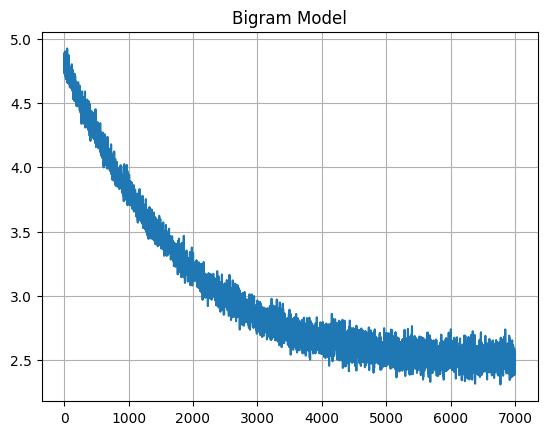

In [32]:
plt.plot(history)
plt.grid()
plt.title("Bigram Model")
plt.show()

In [46]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

y,

SOFRSh!


SI ymybeses, tobabeWinourueay timaoss, einor?
Ondd fe The h d Gon, LOFfrie har; btharo,
D: wqu anghsord HNOUKigucour bet
AceNollf O:

Ariss y h y fl cothounotung-youg spe myowanered KED inome. he!.
Cascoouly.
OMERG$stofas ivif HABulee-ninn aiTh,
IOR: he f m s se ijepelkeareathercerds Why f
S:
Dire frt pat cco ayo wis wiss s in'd thknte s?
WAyon I sa and Bare hatarglNandd the
Awhe ETIUCO:

Thy t
A:
F'd?
Lh weave tasayon
RIOngowoor.
HUCl mes t oleisoro thiloomanghy heat ithe ef s-GKis


## Self-Attention. Intuition

With the bigram model case we only look at a single previous token. It seems only logical to consider all the previous tokens to generate a new one. Now the question is: how do we aggregate the information from all the tokens?

Probably the simplest approach is called _bag of words_: we just average all the tokens to get an aggregated representation.

In [47]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [48]:
# the naive implementation

# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

We want to make this naive implementation efficient. Let's make it with matrix multiplication:

In [ ]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [49]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2, 1e-4)

True

In [50]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
print('masked before softmax:')
print(wei)
wei = F.softmax(wei, dim=-1)
print('after softmax')
print(wei)

xbow3 = wei @ x
torch.allclose(xbow, xbow3, 1e-4)

masked before softmax:
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
after softmax
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1

True

Now we are ready for __self-attention__!

In a nutshell, this mechanism is just a weighted combination of the given embeddings with some tweaks:
- Weights are data-based: model can decide for itself which vector is useful (and we should give it bigger weight) and which is not
- Instead of a raw input we operate with projections: _Key_, _Query_, _Value_

In [51]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
# some mnemonic rules:
query = nn.Linear(C, head_size, bias=False)  # what I'm looking for
key = nn.Linear(C, head_size, bias=False)  # what I can give you
value = nn.Linear(C, head_size, bias=False)  # what is the value for original token

k = key(x)   # (B, T, C) @ (C, 16) ---> (B, T, 16)
q = query(x) # (B, T, C) @ (C, 16) ---> (B, T, 16)

## it was
#wei = torch.zeros((T,T))
## now it's
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)

## it was
#out = wei @ x
## now it's
out = wei @ v

out.shape

torch.Size([4, 8, 16])

In [52]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5877, 0.4123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4457, 0.2810, 0.2733, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2220, 0.7496, 0.0175, 0.0109, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0379, 0.0124, 0.0412, 0.0630, 0.8454, 0.0000, 0.0000, 0.0000],
        [0.5497, 0.2187, 0.0185, 0.0239, 0.1831, 0.0062, 0.0000, 0.0000],
        [0.2576, 0.0830, 0.0946, 0.0241, 0.1273, 0.3627, 0.0507, 0.0000],
        [0.0499, 0.1052, 0.0302, 0.0281, 0.1980, 0.2657, 0.1755, 0.1474]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [53]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei_no_norm = q @ k.transpose(-2, -1)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [54]:
k.var()

tensor(1.0449)

In [55]:
q.var()

tensor(1.0700)

In [56]:
wei_no_norm.var()

tensor(17.4690)

In [57]:
wei.var()

tensor(1.0918)

In [58]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [59]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [60]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [61]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [62]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-3.5763e-09), tensor(1.0000))

In [63]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the [git repo](https://github.com/karpathy/nanoGPT) instead though.

In [64]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLikeModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLikeModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4195, val loss 2.4335
step 400: train loss 2.3501, val loss 2.3562
step 500: train loss 2.2965, val loss 2.3129
step 600: train loss 2.2410, val loss 2.2497
step 700: train loss 2.2049, val loss 2.2187
step 800: train loss 2.1637, val loss 2.1869
step 900: train loss 2.1233, val loss 2.1493
step 1000: train loss 2.1026, val loss 2.1307
step 1100: train loss 2.0704, val loss 2.1189
step 1200: train loss 2.0386, val loss 2.0800
step 1300: train loss 2.0256, val loss 2.0645
step 1400: train loss 1.9925, val loss 2.0360
step 1500: train loss 1.9724, val loss 2.0314
step 1600: train loss 1.9633, val loss 2.0482
step 1700: train loss 1.9412, val loss 2.0126
step 1800: train loss 1.9116, val loss 1.9984
step 1900: train loss 1.9065, val loss 1.9857
step 2000: train loss 1.8859, val loss 1.9960
step 2100: train loss 1.

---